Задача:

🔸детектировать табличную часть справки и распознать  текст.

🔸Оценить качество этого решения на данных, предоставленных заказчиком. Метрика: acc

Этапы работы:
1. Выбор решения: поиск реппозитория или статьи и применение решения на данных (27.06 - 4.07)
2. Сравнение результатов с CSV данными - проверка качества проверки данных и улучшение качетсва (4.07 - 11.07)
3. Создание микросервиса  (11.07 - 18.07)

На справках нужно распознать:

✅ полная дата донации (число, месяц, год в формате дд.мм.
гггг)

✅ тип донации (платно или безвозмездно)

✅ вид донации (цельная кровь, плазма, тромбоциты,
эритроциты, гранулоциты (лейкоциты))

✅ центр крови

➕ Если получится, то город.

🔥Условные обозначения в справке🔥:

кр/д - кроводача (то есть цельная кровь)
пл/д - плазмадача (плазма) 
ц/д - цитосдача (тромбоциты)

БВ - это безвозмездно, а ПЛАТ - это платно.

- обработка:
    * изменить положение картинки, т.е. повернуть и увеличить изображение (OpenCV)
    * увеличить разрешение (torch)
    * размытие (нейросетью)
- 3 типа изображений: 8, 9, 4 колонок в таблице
- извлечение таблицы:
    * пометить области ячеек таблицы (координаты)
    * извлечь текст из каждой ячейки (pytesseract)

<h2>Детекция печати</h2>

In [22]:
import cv2
import numpy as np
import pandas as pd
import pytesseract
from glob import glob
import matplotlib.pyplot as plt

# pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [23]:
imgs = glob('../data/yandex/405/pic/*')

In [24]:
img = cv2.imread('../data/yandex/405/pic/236000 .jpg')

In [25]:
def imshow(img, showAxis = False, size=(20,10)):
    plt.figure(figsize=size)
    if not showAxis: plt.axis('off')
    if len(img.shape) == 3: plt.imshow(img[:,:,::-1])
    else: plt.imshow(img, cmap='gray')

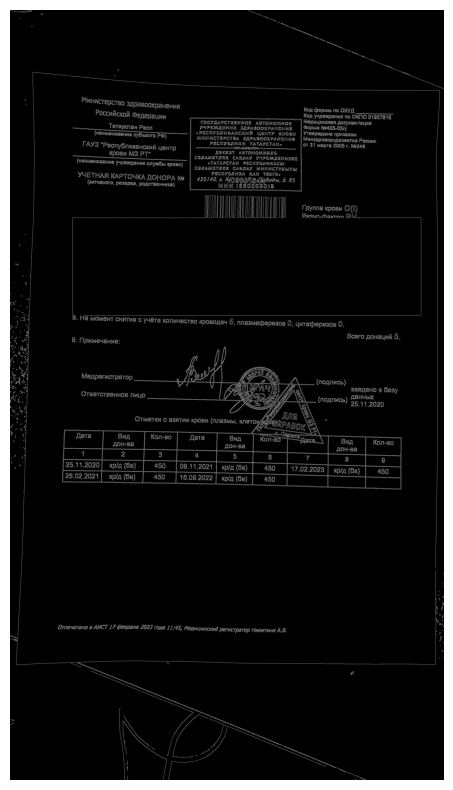

In [26]:
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

# Blur to remove noise
blur = cv2.bilateralFilter(gray.copy(), 15, 15, 15 )

# Find edges using canny edge detector
def auto_canny(grayim, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(grayim)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(grayim, lower, upper)
    # return the edged image
    return edged

# Find the edges and display the image
edged = auto_canny(blur)
imshow(edged)

In [27]:
# detect the contours on the binary image
contours, _ = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(f'Total nr of contours found: {len(contours)}')

# Sort Contours by Area and get topN
topN = 10
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)                     
sorted_contours = sorted_contours[:topN]

Total nr of contours found: 1519


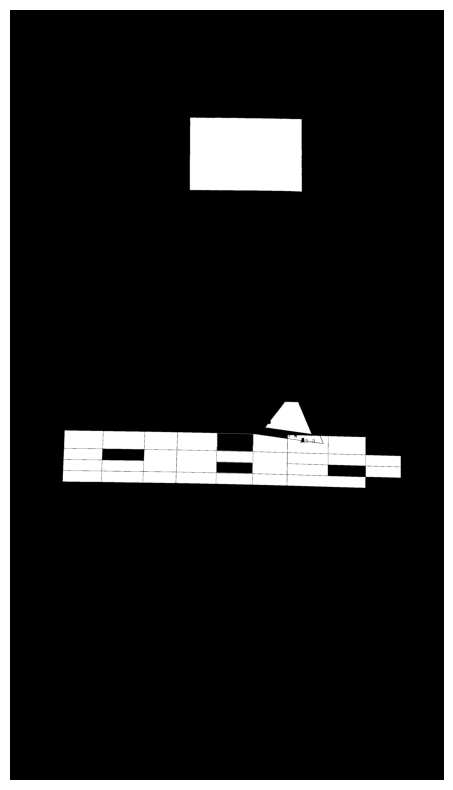

In [28]:
filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)
cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
imshow(filteredCircle)

<h2>Распознавание текста с помощью img2table</h2>

In [1]:
from img2table.document import Image
from img2table.ocr import TesseractOCR

In [4]:
src = '../data/yandex/405/pic/236000 .jpg'
image = Image(src, detect_rotation=True)

In [9]:
# Instantiation of OCR
ocr = TesseractOCR(n_threads=1, lang="rus")

# Instantiation of document, either an image or a PDF
doc = Image(src)

# Table extraction
extracted_tables = doc.extract_tables(ocr=ocr,
                                      implicit_rows=True,
                                      borderless_tables=True,
                                      min_confidence=50)

In [10]:
extracted_tables

[ExtractedTable(title=8. На момент снятия с учёта количество кроводач 5, плазмаферезов 0,
 цитаферезов 0.
 Всего донаций 5.
 9. Примечание:
 Л
 ЕЙ р
 Медрегистратор
 (подпись)
 введено в базу
 Ответственное лицо
 данных
 (подпись)
 25.11.2020
 7
 ДЛЯ
 СУ
 Отметки о взятии крови (плазмы, клето, bbox=(278, 2210, 2043, 2496),shape=(9, 7))]

<h2>Распознавание таблицы с помощью paddlepaddle</h2>

In [26]:
pip install paddlepaddle-gpu==2.4.2.post117 -f https://www.paddlepaddle.org.cn/whl/windows/mkl/avx/stable.html

Looking in links: https://www.paddlepaddle.org.cn/whl/windows/mkl/avx/stable.html
  Using cached https://paddle-wheel.bj.bcebos.com/2.4.2/windows/windows-gpu-cuda11.7-cudnn8.4.1-mkl-avx-vs2019/paddlepaddle_gpu-2.4.2.post117-cp39-cp39-win_amd64.whl (489.3 MB)
  Attempting uninstall: paddlepaddle-gpu
    Found existing installation: paddlepaddle-gpu 2.5.0
    Uninstalling paddlepaddle-gpu-2.5.0:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\python3.9.13\\lib\\site-packages\\paddle\\fluid\\libpaddle.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
# pip install paddleocr --upgrade
# pip install paddlepaddle

In [7]:
import paddle

In [8]:
paddle.utils.run_check()

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


In [5]:
# wget https://paddleocr.bj.bcebos.com/whl/layoutparser-0.0.0-py3-none-any.whl
# pip install -U layoutparser-0.0.0-py3-none-any.whl

Processing c:\users\1rati\jupyter\yandex_job\layoutparser-0.0.0-py3-none-any.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\1rati\\Jupyter\\Yandex_job\\layoutparser-0.0.0-py3-none-any.whl'



In [43]:
from paddleocr import PaddleOCR,draw_ocr

In [9]:
import layoutparser as lp
import cv2

In [30]:
import matplotlib.pyplot as plt

In [37]:
# img_path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/236000 .jpg'
img_path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/254586 .jpg'
# img_path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/213950.jpg'
img = cv2.imread(img_path)

model = lp.PaddleDetectionLayoutModel(config_path='lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publaynet/config',
                                      threshold=0.5,
                                      label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                                      enforce_cpu=False,
                                      enable_mkldnn=True)

In [38]:
layout = model.detect(img)

In [39]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=16.0074462890625, y_1=3.573486328125, x_2=658.5125122070312, y_2=976.4075927734375), text=None, id=None, type=Figure, parent=None, next=None, score=0.8569985032081604), TextBlock(block=Rectangle(x_1=61.987762451171875, y_1=593.549072265625, x_2=648.6646728515625, y_2=722.5091552734375), text=None, id=None, type=Table, parent=None, next=None, score=0.8311167359352112), TextBlock(block=Rectangle(x_1=181.26919555664062, y_1=565.7260131835938, x_2=442.2879333496094, y_2=581.9464721679688), text=None, id=None, type=Text, parent=None, next=None, score=0.5499403476715088)], page_data={})

In [40]:
for l in layout:
    if l.type == 'Table':
        x_1 = int(l.block.x_1)
        x_2 = int(l.block.x_2)
        y_1 = int(l.block.y_1)
        y_2 = int(l.block.y_2)

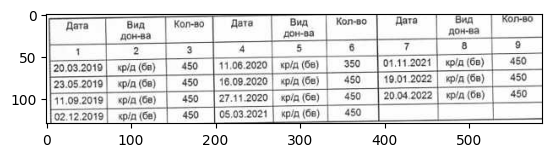

In [41]:
plt.imshow(img[y_1:y_2, x_1:x_2])

In [52]:
path = '../data/yandex/405/1.jpg'
cv2.imwrite(path, img[y_1:y_2, x_1:x_2])

True

In [60]:
ocr = PaddleOCR(use_angle_cls=True, lang='ru') # need to run only once to download and load model into memory
# img_path = '../data/yandex/405/pic/236000 .jpg'
result = ocr.ocr(path, cls=True)

[2023/07/11 14:18:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\1rati/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\1rati/.paddleocr/whl\\rec\\cyrillic\\cyrillic_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, 

In [77]:
boxes = [line[0] for line in result[0]]
texts = [line[1][0] for line in result[0]]
probs = [line[1][1] for line in result[0]]
for text in texts:
    print(text)

ета
Еид
нiе
Еид
на
Eн
пh
дHe
ргд
ер
дг
е
д
HE
д
E.
гд
еe
E
ргд
Tв
Tihge.
це
хрд
чэ
.н
гд
е
рд
He
е
DEge.
е


<h4>Вывод: русские буквы плохо распознаются. Нужно тренировать нейросеть</h4>

<h2>Выпрямление страницы с помощью page_dewarp</h2>

In [81]:
from page_dewarp import image
from page_dewarp.pdf import save_pdf
from page_dewarp.options import cfg

In [82]:
path = 'C:/Users/1rati/Jupyter/data/yandex/405/pic/141899 .jpg'
outfiles = []
processed_img  = image.WarpedImage(path)
if processed_img.written:
    outfiles.append(processed_img.outfile)
    print(f"  wrote {processed_img.outfile}", end="\n\n")

if cfg.pdf_opts.CONVERT_TO_PDF:
    save_pdf(outfiles)



Loaded 141899 .jpg at size='685x1000' --> resized='342x500'
  got 23 spans with 104 points.
  initial objective is 0.00451534504846275
  optimizing 135 parameters...
  optimization took 1.28 sec.
  final objective is 0.0029787985973783603
  got page dims 0.9993459088203808 x 1.87929327745737
  output will be 512x944
  wrote 141899 _thresh.png



In [84]:
im = cv2.imread('../Yandex_job/141899 _thresh.png')

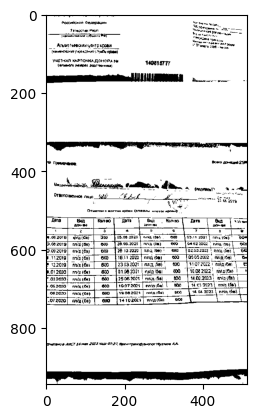

In [85]:
plt.imshow(im)

<h4>Вывод: качество ухудшилось, страница не выровнена</h4>

<h2>DataFrame из таблицы</h2>

In [87]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [88]:
pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [90]:
pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25870 sha256=6a9b9484314b70040f5bbb9b5aeb4594116b5239c27fcef7c58850273cdcf72f
  Stored in directory: c:\users\1rati\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [91]:
# import the necessary packages
from sklearn.cluster import AgglomerativeClustering
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [92]:
# load the input image and convert it to grayscale
image = cv2.imread('C:/Users/1rati/Jupyter/data/yandex/405/pic/141899 .jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

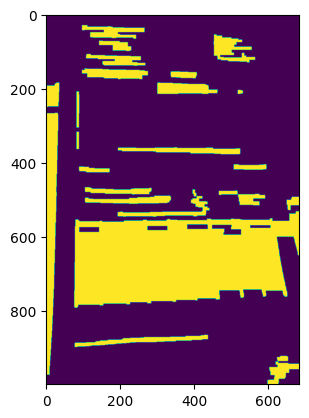

In [94]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morphological operator to find dark regions on a light
# background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
# apply a closing operation using the rectangular kernel to close
# gaps in between characters, apply Otsu's thresholding method, and
# finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt.imshow(thresh)

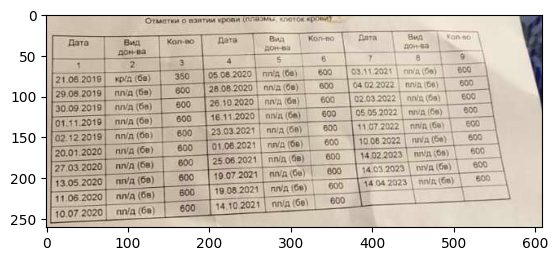

In [98]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)

# compute the bounding box coordinates of the stats table and extract
# the table from the input image
(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]

# show the original input image and extracted table to our screen
# plt.imshow(image)
plt.imshow(table)

In [99]:
# set the PSM mode to detect sparse text, and then localize text in
# the table
options = "--psm 6"
results = pytesseract.image_to_data(
	cv2.cvtColor(table, cv2.COLOR_BGR2RGB),
	config=options,
	output_type=Output.DICT)
# initialize a list to store the (x, y)-coordinates of the detected
# text along with the OCR'd text itself
coords = []
ocrText = []

In [105]:
# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(results["conf"][i])
	# filter out weak confidence text localizations
# 	if conf > args["min_conf"]:
	if conf > 0: # 10
		# update our text bounding box coordinates and OCR'd text,
		# respectively
		coords.append((x, y, w, h))
		ocrText.append(text)

In [107]:
# extract all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]
# apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
	n_clusters=None,
	affinity="manhattan",
	linkage="complete",
	distance_threshold=25.0)
clustering.fit(xCoords)
# initialize our list of sorted clusters
sortedClusters = []

In [109]:
# loop over all clusters
for l in np.unique(clustering.labels_):
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]
	# verify that the cluster is sufficiently large
	if len(idxs) > 2:
		# compute the average x-coordinate value of the cluster and
		# update our clusters list with the current label and the
		# average x-coordinate
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))
# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [110]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]
	# extract the y-coordinates from the elements in the current
	# cluster, then sort them from top-to-bottom
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]
	# generate a random color for the cluster
	color = np.random.randint(0, 255, size=(3,), dtype="int")
	color = [int(c) for c in color]

In [111]:
	# loop over the sorted indexes
	for i in sortedIdxs:
		# extract the text bounding box coordinates and draw the
		# bounding box surrounding the current element
		(x, y, w, h) = coords[i]
		cv2.rectangle(table, (x, y), (x + w, y + h), color, 2)
	# extract the OCR'd text for the current column, then construct
	# a data frame for the data where the first entry in our column
	# serves as the header
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})
	# concatenate *original* data frame with the *current* data
	# frame (we do this to handle columns that may have a varying
	# number of rows)
	df = pd.concat([df, currentDF], axis=1)

+----+-----+
|    | |   |
|----+-----|
|  0 | |   |
|  1 | oo  |
|  2 | |   |
|  3 | |   |
|  4 | |   |
|  5 | |   |
|  6 | 800 |
|  7 | |   |
|  8 | |   |
|  9 | |   |
+----+-----+
[INFO] saving CSV file to disk...


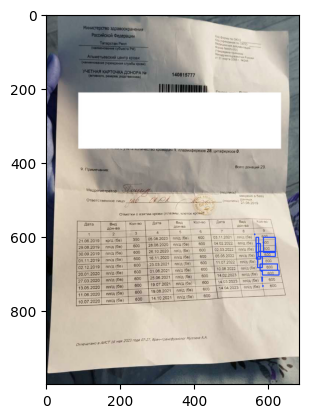

In [118]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))
# write our table to disk as a CSV file
print("[INFO] saving CSV file to disk...")
# df.to_csv('C:/Users/1rati/Jupyter/data/yandex/405', index=False)
# show the output image after performing multi-column OCR
plt.imshow(image)
# cv2.waitKey(0)